# Test case I / one dimensional compressible SPH
This notebook is meant to demonstrate how we can run an SPH simulation in pytorch, use this data directly to train a neural network and then directly include the neural network back into the simulation. This also shows how easy it is to run the same code on GPU and CPU.

Before proceeding further, however, we first need to install some necessary libraries that are not included in Google colab by default (these are used for the neighborhood search)

In [1]:
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())
# !pip install torch-geometric

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [3]:
# sph related imports
from src.oneDimensionalSPH.sph import initSimulation, runSimulation
from src.oneDimensionalSPH.perlin import generate1DPeriodicNoise
from src.oneDimensionalSPH.io import export
from src.oneDimensionalSPH.plotting import plotSimulationState, regularPlot
# neural network rlated imports
from torch.optim import Adam
# from rbfConv import *
# from torch_geometric.loader import DataLoader
# from trainingHelper import *
# plotting/UI related imports
import matplotlib as mpl
# plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
from datetime import datetime
import h5py
import torch
import numpy as np
import scipy
%matplotlib notebook

# Initial particle density sampling
First we setup the initial distribution of the particles. This is done by defining a PDF (probability density function) which is later used to sample particles such that the resulting density field is equal to the PDF.

Note that to be useful the pdf should always be greater than 0, e.g., it may b useful to shift a pdf you want to sample by a constant factor.

Different PDFs are included here and you should paste the one you want into the field below to use it:

### Sinusoidal Sampling
This is a simple sampling with 4 peaks in the $[-1,1]$ domain. This pdf is shifted by 2 with an intensity of 1 on the sinusoidal wave, i.e., the minimum density is 1 and the maximum density is 3.
```python
pdf = lambda x: np.sin(x * np.pi * 4) + 2
```
### Low Frequency Sinusoidal Sampling
This sinusoidal sampling is of a lower frequency, i.e. there is only a single peak in the domain $[-1,1]$ but this is mostly to show an alternative way to define a pdf by using linear interpolation of an arbitrary set of datapoints.
```python
noise = 15 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```
### Square profile
This profile has a peak over $[-\frac{1}{3},\frac{1}{3}]$ where the density is at 2 and 1 everywhere else. This is useful to create a single well defined wave. 
```python
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out + 7
```
### Sawtooth profile
This profile creates a discontinuous profile where the sampled density changes from $2$ to $1$ at $x=0$ instantly and linearly ramps between these valus, creating a sawtooth profile.
```python
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 10
```
### Sharp Sawtooth profile
This profile has a discontinuity at $x=-1$ where the sampled density changes from $2$ to $0$. This 0 density is interesting but should be avoided due to the sampling we use.
```python
pdf = lambda x: 1 + x
```
### Triangular profile
This profile has a peak at $x=0$ with a density of $2$ and linarly ramps to $1$ at the edges of the domain
```python
pdf = lambda x: np.abs(x) + 1
```
### Gaussian profile
This profile is a smoothed variant of th above, change the standard deviation (the $8$) to change how broad the profile is.
```python
pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
```
### Uniform profile
This profile is mostly useful for debugging as nothing should happen in this case.
```python
pdf = lambda x: np.ones_like(np.array(x))
```
### Random profile
This profile uses a periodic noise generation, using Perlin noise, to create an octav noise that can be used to generate a lot of different samplings with high frequency components that are still somewhat _smooth_
```python
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```

In [4]:
numParticles = 2048 # Modify th number of desird particles here, this value is defined here to ensure that the linar sampling for some pdfs is accurate.
generator = 'perlin'
generatorSettings = {'r' : 0.75, 'freq' : 1, 'octaves' : 2, 'seed' : 1234, 'mag' : 0.25, 'offset': 2}
noise  = generatorSettings['offset'] + generate1DPeriodicNoise(numSamples = numParticles, r = generatorSettings['r'], freq = generatorSettings['freq'], octaves = generatorSettings['octaves'], plot = False, seed = generatorSettings['seed']) * generatorSettings['mag']
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)

def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1

# Setup of simulation parameters

Before running the simulation we need to setup some necessary physical parameters:

Parameter | Default | Meaning
---|---|---
minDomain | -1 | The minimum extent of the simulation domain, should be left at -1
maxDomain | 1  | The maximum extent of the simulation domain, should be left at -1
baseArea | 2 / numParticles * 2 | The area (or length) represented by a single particle set based on the simulation domain size and particle count
particleSupport | particlRadius * 8. | The support radius, reducing this value makes the simulations sharper but also less stable so change with caution
xsphConstant | 0.0 | Diffusion coefficient for the XSPH velocity diffusion term. Used as an artificial viscosity but superceeded by the dynamic viscosity
diffusionAlpha | 1.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
diffusionBeta | 2.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
c0 | 10 | Speed of sound, used for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
kappa | 10 | Coefficient for the ideal gas EOS
restDensity | 1000 | Coefficient for the ideal gas EOS
dt | 1e-3 | Fixed timestep used for the simulation

Additionally some further parameters need setting up:

Parameter | Default | Meaning
---|---|---
timesteps | 2048 | Number of timesteps that should be simulated
device | 'cuda' | Set to 'cuda' to run on an nvidia GPU and 'cpu' to run in a multithreaded CPU mode.
dtyp | torch.float32 | default numerical precision, should be set to torch.float32 if using GPUs or other accelerators due to their limited FP32 performance.

In [5]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.0
diffusionAlpha = 1. # kinematic viscosity coefficient
diffusionBeta = 2.
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 10 # speed of sound used in kinematic viscosity

timesteps = 2048 # timesteps to be simulated
# display(Latex(f'Estimated kinematic diffusion $\\mu\\approx\\frac{{1}}{{2(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport:4.2e} = {1/6 * diffusionAlpha * c0 * particleSupport:4.2e}$'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if device == 'cpu' else torch.float32
# print('Running on ', device, 'using type', dtype)

## Initialization of the simulation

To run the simulation we now need to:
1. Sample the desired density distribution (i.e., the pdf). This sampling is done using the inverse cdf of the pdf
2. Create particles based on the sampled pdf with appropriate velocities and areas
3. Initialize a structure that holds the simulation results
4. Verify that the simulation was set up correctly by visualizing the initial density distribution

<IPython.core.display.Javascript object>


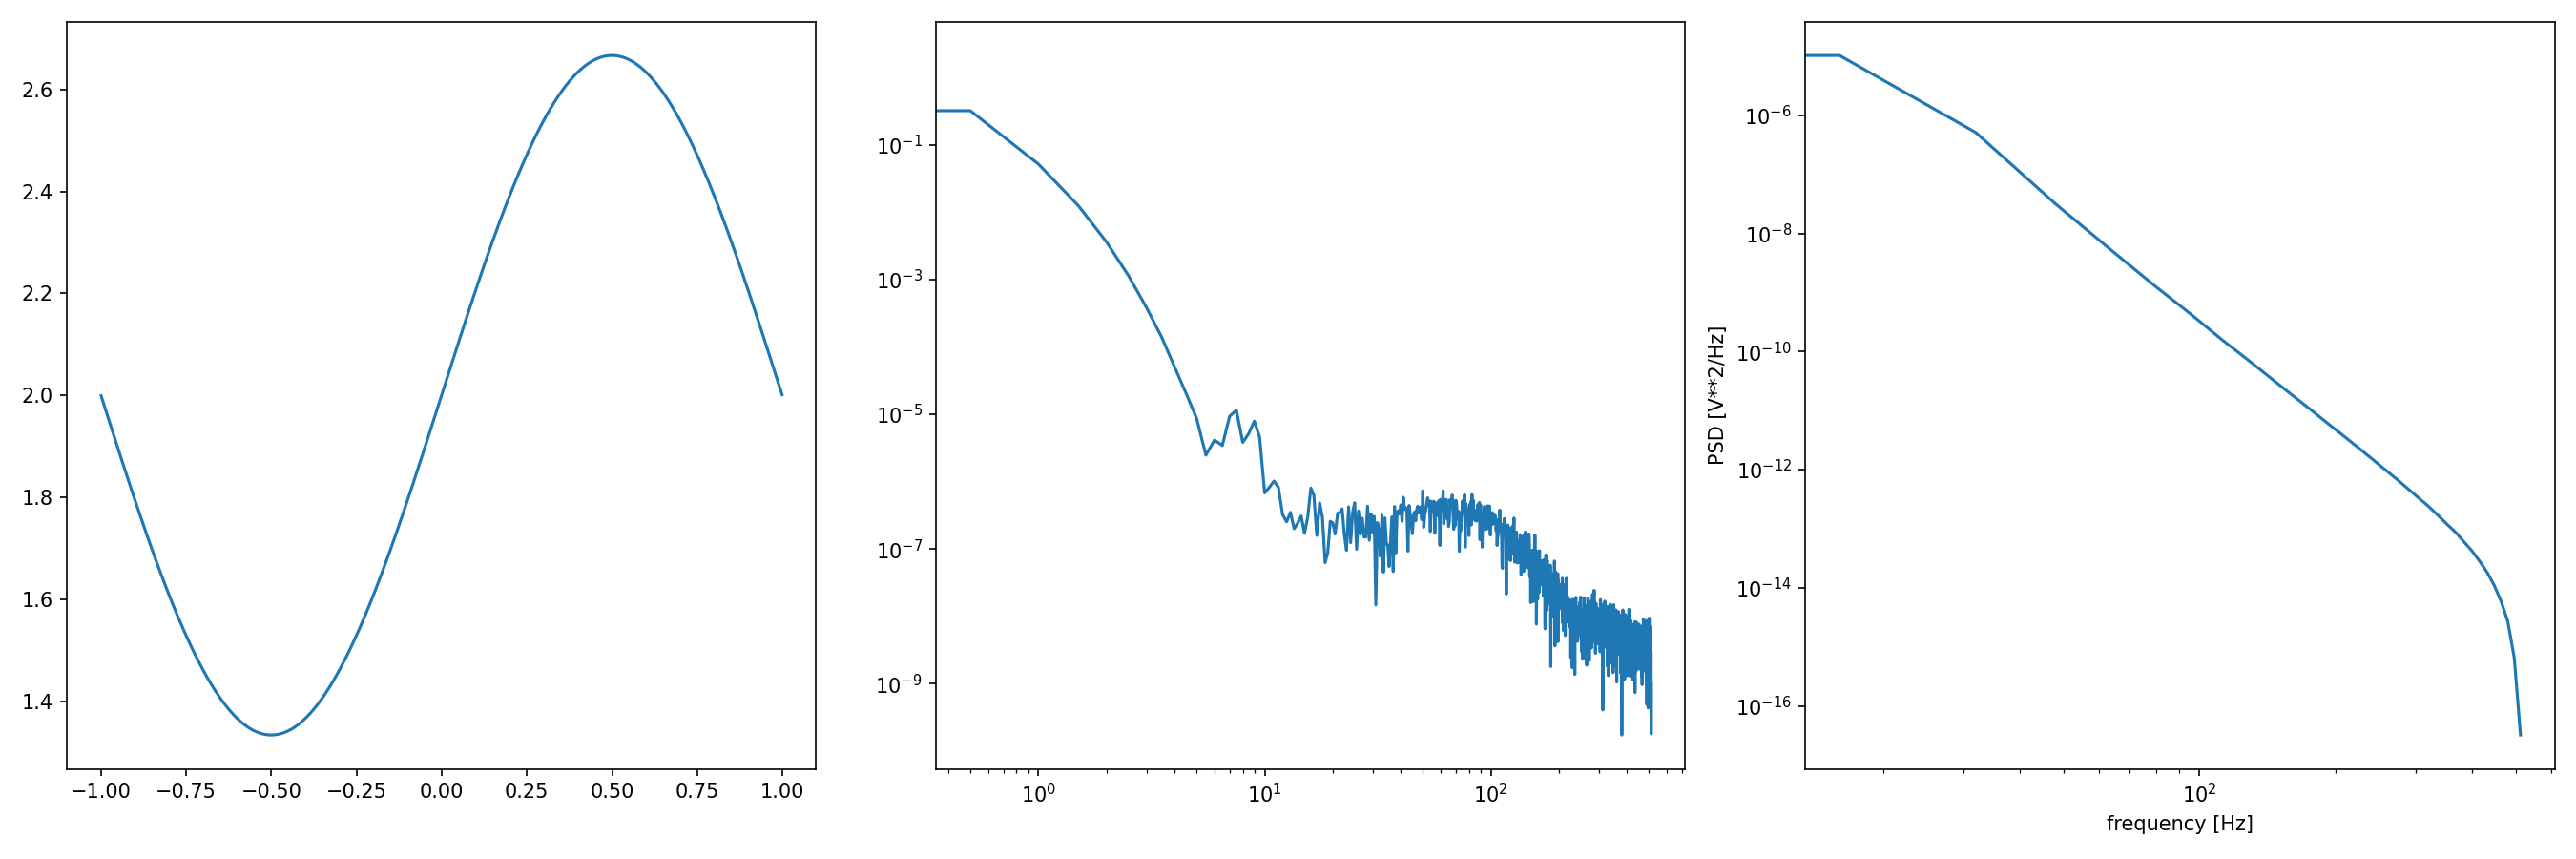

In [6]:

noise = 15 + 5 * np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)

fluidPositions, fluidAreas, fluidVelocities = initSimulation(pdf, numParticles, minDomain, maxDomain, baseArea, particleSupport, dtype, device, plot = True)

## Running the simulation based on an RK4 time integrator

The actual simulation proceeds by calling the computeUpdate function that takes the current simulation state and returns (per particle) $\frac{du}{dt}$, $\frac{dx}{dt}$, $\rho$ and $p$.

Note that we use a summation density approach to have something straight forward to learn, computing $\frac{d\rho}{dt}$ would also be possible but using a summation density makes the initial sampling more straightforward.

The updates are then computed according to the normal RK4 time integration scheme:

$$
\begin{align}
k_1 &= f(t^n, y^n)\\
k_2 &= f\left(t^n + \frac{h}{2}, y^n + h \frac{k_1}{2}\right)\\
k_3 &= f\left(t^n + \frac{h}{2}, y^n + h \frac{k_2}{2}\right)\\
k_4 &= f\left(t^n + h, y^n + h k_3\right)
\end{align}
$$

With $y^n = u_i^t$, i.e., we only update the velocities so that this becomes a first order PDE. Accordingly, we can then compute the new velocities and positions (using the updated velocity) as:
$$
\begin{align}
u_i^{n+1} &= u_i^n + \frac{h}{6}\left(k_1 + k_2 + k_3 + k_4\right)\\
x_i^{n+1} &= x_i^n + h u_i^{n+1}\\
t^{n+1} &= t^n + h
\end{align}
$$
with $h=dt$

In [7]:
simulationStates = runSimulation(fluidPositions, fluidAreas, fluidVelocities, timesteps, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


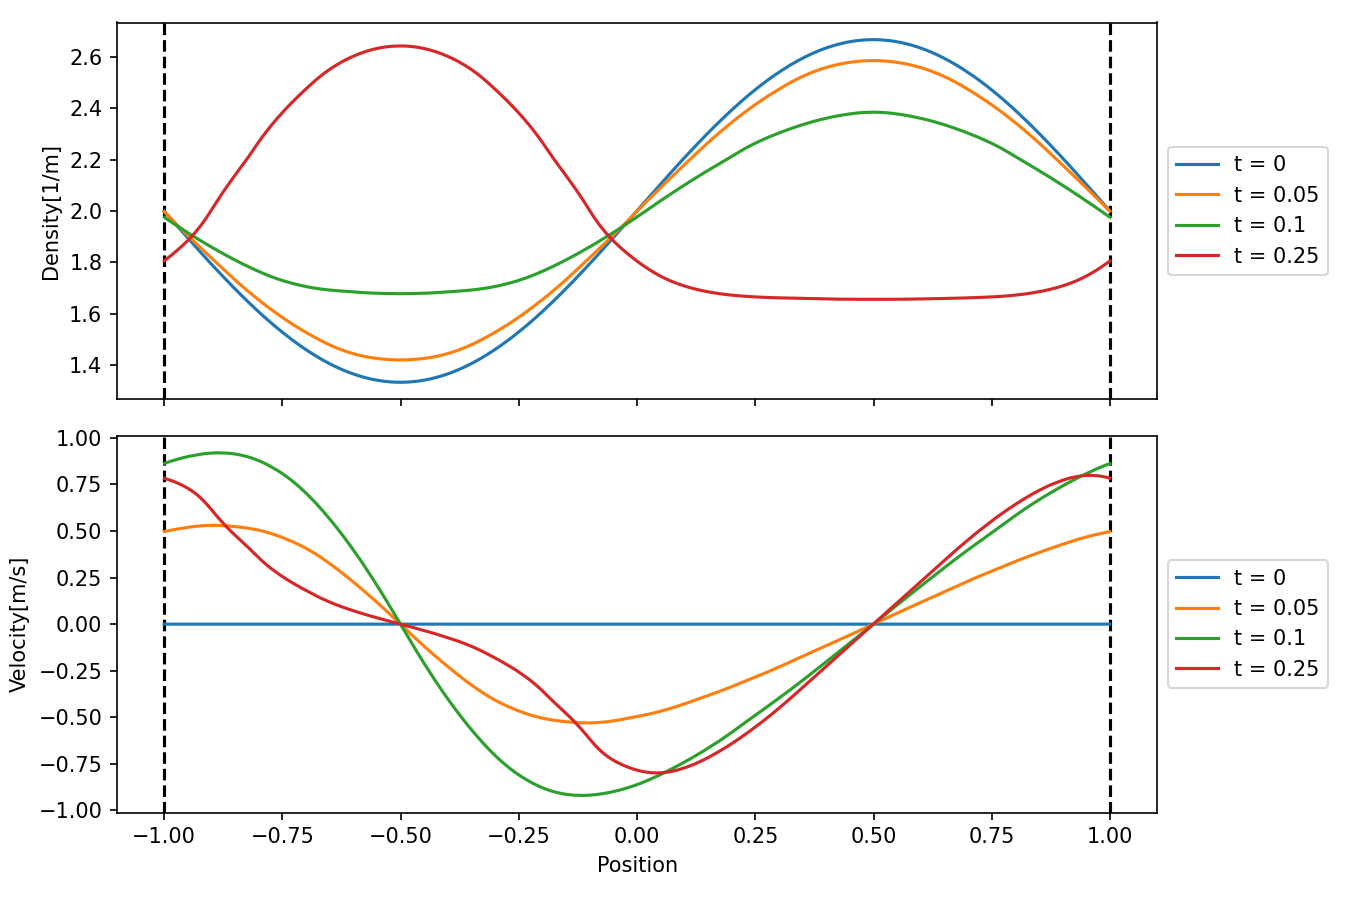

<IPython.core.display.Javascript object>


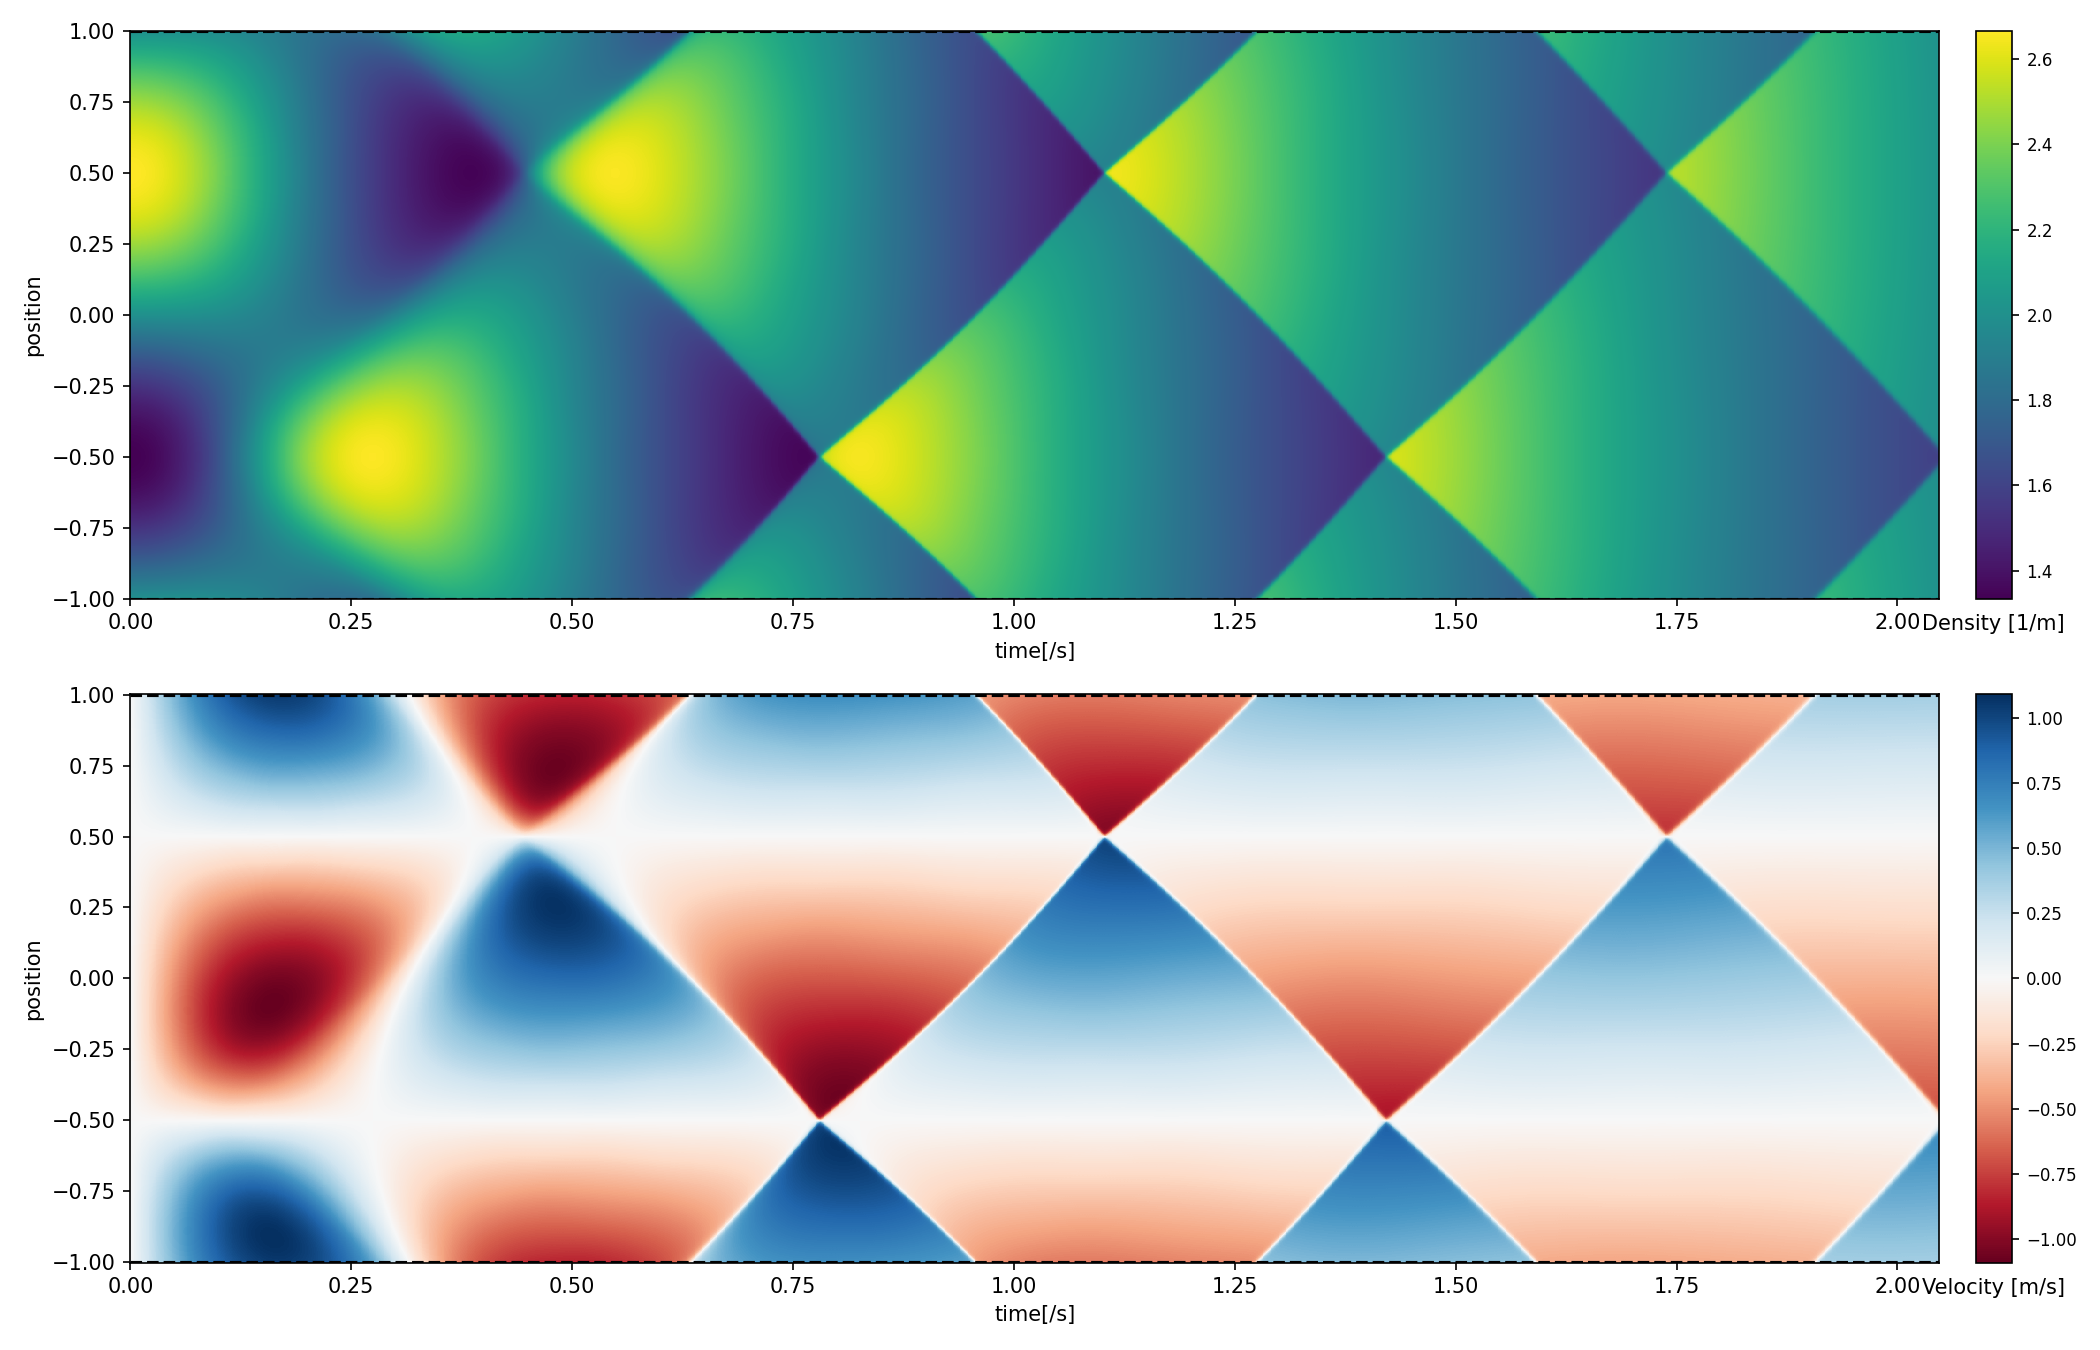

In [8]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250]) # This plots the simulation at the given timesteps, useful to see the behavior in detail, e.g., to check if any ripples exist that should not be there
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps) # Plots the entire simulation run with time on the y-axis as a pseudo 2D plot.